# Introduction

### Problem statement
More than 1 million people are hospitalized with pneumonia each year, which is a very serious problem. Chest X-Rays are currently the best method available for diagnosing it. The task is to classify if a person has pneumonia or not. Further, the classification model has to be deployed onto a mobile device for real time inference.

The following link contains information about the popular existing applications in medical dimain: https://www.grantsformedical.com/apps-for-medical-diagnosis.html

The above was especially useful during the times when COVID-19 was known to cause pneumonia.

The image below shows a visual comparison of a normal lung (left) and a lung affected by pneumonia (right).

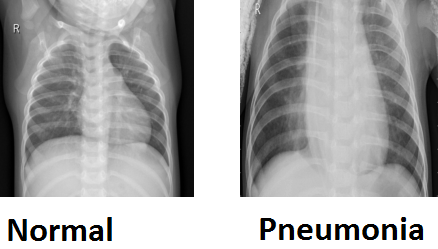

Observe that there is severe glass opacity in the image on the right  mainly due to air displacement by fluids.

### What is pneumonia?
Pneumonia is a lung infection that inflames the air sacs within the lungs. These air sacs, known as alveoli, can become filled with fluids or pus, hindering the efficient exchange of oxygen and carbon di-oxide. This can lead to a range of symptoms, including,
- Cough (often producing phlegm or pus).
- Fever or chills.
- Difficulty breathing.
- Chest pain.
- Fatigue.
- Confusion (particularly in older adults).

Various microorganisms, such as bacteria, viruses (like influenza or the virus that causes COVID-19) and fungi can cause pneumonia.

The severity of pneumonia can vary widely, from mild to life-threatening. Individuals at higher rist of severe illness include,
- Infants and young children.
- Adults aged 65 and older.
- People with weakened immune systems.
- Individuals with underlying health conditions such as chrinic lung diseases (asthma, CPOD), heart disease or diabetes.

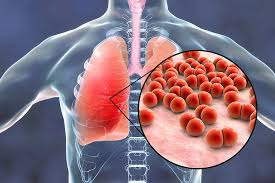

### Agenda and motivation
